# Env

In [182]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import scipy as sp

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [183]:
data_dir = '~/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

In [184]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [185]:
train.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,...,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,310000.0,3,1.00,1430,19901,1.5,0,0,...,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,20141007T000000,400000.0,3,1.75,1370,9680,1.0,0,0,...,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,20150312T000000,530000.0,5,2.00,1810,4850,1.5,0,0,...,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


In [186]:
# 간략한 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [187]:
# 기초 통계량 확인
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


<AxesSubplot:>

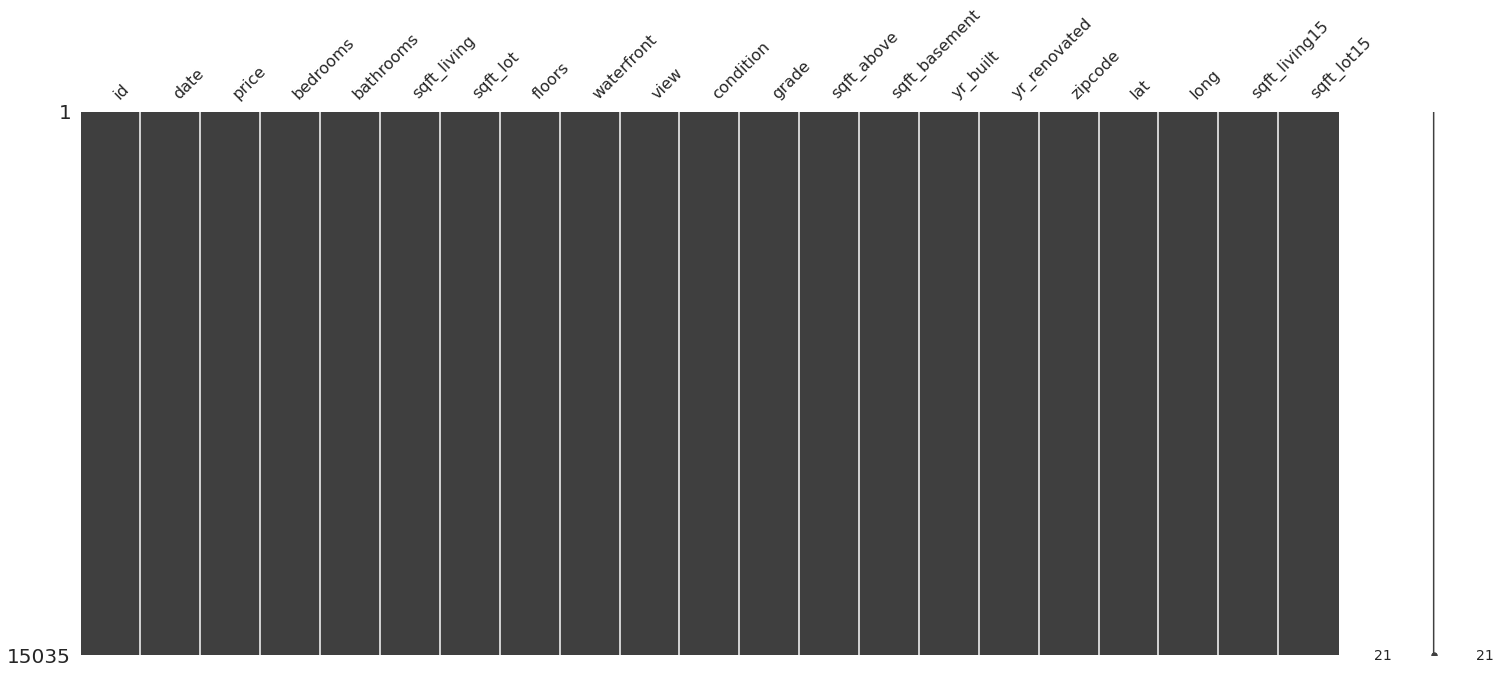

In [188]:
# 결측치 확인
ms.matrix(train)

In [189]:
# 'date'열에서 필요없는 부분 삭제하고 모델 특성으로 바꾸기 위해 int형으로 변환하기
train['date'] = train['date'].apply(lambda i : i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i : i[:6]).astype(int)

In [190]:
# train, test에 필요없는 칼럼 삭제
del test['id']
del train['id']

train.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

<AxesSubplot:xlabel='price', ylabel='Density'>

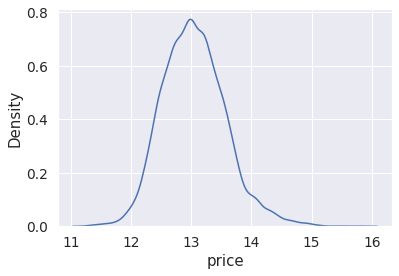

In [191]:
train['price'] = np.log1p(train['price'])

sns.kdeplot(train['price'])

In [192]:
# 잘 사라졌나 확인
display(train.head(10))
display(test.head(10))

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,201504,13.403777,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,201405,13.056226,2,1.00,1160,6000,1.0,0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,201405,12.644331,3,1.00,1430,19901,1.5,0,0,4,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,201410,12.899222,3,1.75,1370,9680,1.0,0,0,4,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,201503,13.180634,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
5,201407,5,2.50,2270,6300,2.0,0,0,3,8,2270,0,1995,0,98092,47.3266,-122.169,2240,7005
6,201406,3,1.75,1520,6380,1.0,0,0,3,7,790,730,1948,0,98115,47.6950,-122.304,1520,6235
7,201503,4,2.50,2570,7173,2.0,0,0,3,8,2570,0,2005,0,98052,47.7073,-122.110,2630,6026
8,201412,2,1.50,1190,1265,3.0,0,0,3,7,1190,0,2005,0,98133,47.7274,-122.357,1390,1756
9,201405,4,1.00,1660,34848,1.0,0,0,1,5,930,730,1933,0,98052,47.6621,-122.132,2160,11467


['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

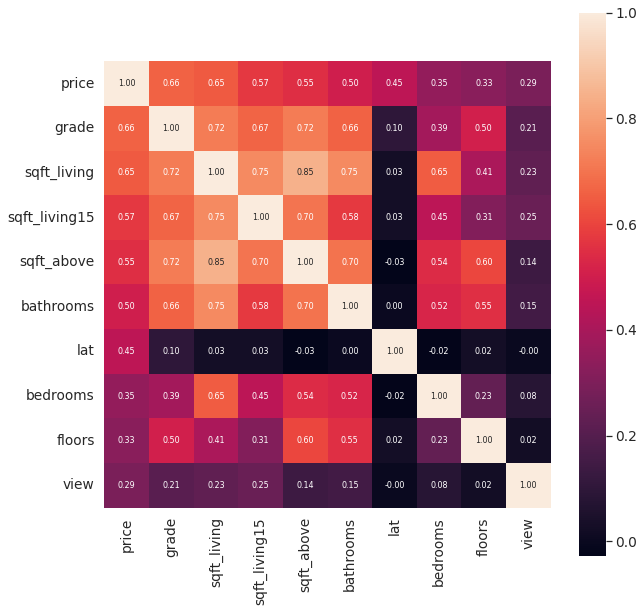

In [193]:
# correlation이 높은 상위 10개의 heatmap
# abs는 음의 상관관계 고려

cor_abs = abs(train.corr(method='spearman')) 
# price과 correlation이 높은 column 10개 뽑기(내림차순)
cor_cols = cor_abs.nlargest(n=10, columns='price').index 

# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , 
            annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

집의 등급, 주거공간 크기, 전체 크기, 지하 제외한 크기 등 가격이 비싸짐 <br>
위도도 꽤나 높음, 잘사는 동네 못사는 동네를 의미하는 듯?

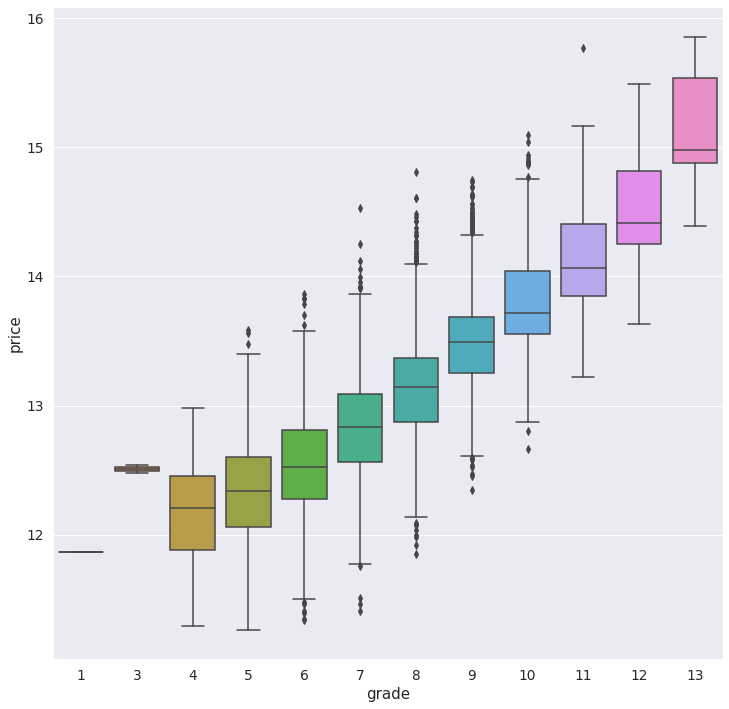

In [194]:
f, ax = plt.subplots(figsize=(12, 12))
fig = sns.boxplot(x = 'grade', y = 'price', data = train)

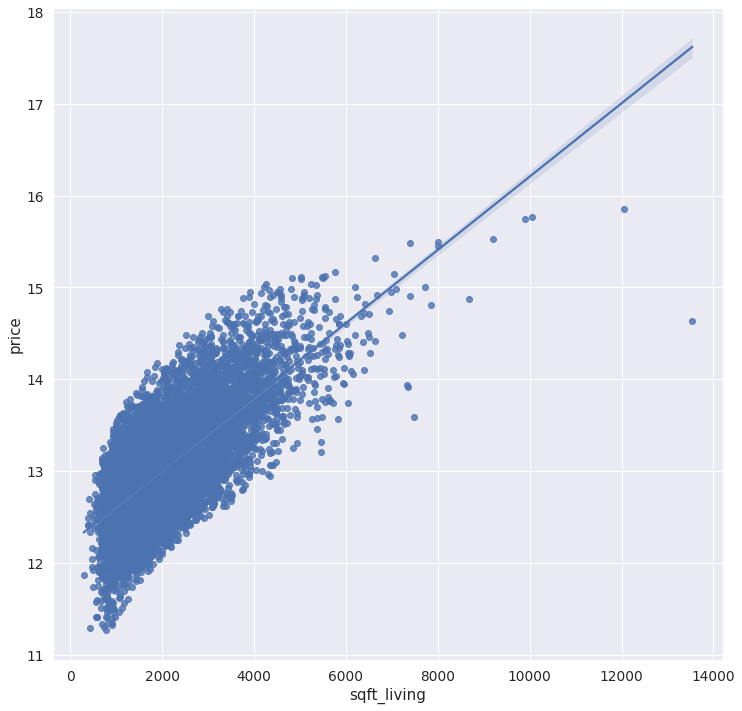

In [195]:
f, ax = plt.subplots(figsize=(12, 12))
fig = sns.regplot(x = 'sqft_living', y = 'price', data = train)

# 이상치가 꽤나 보임

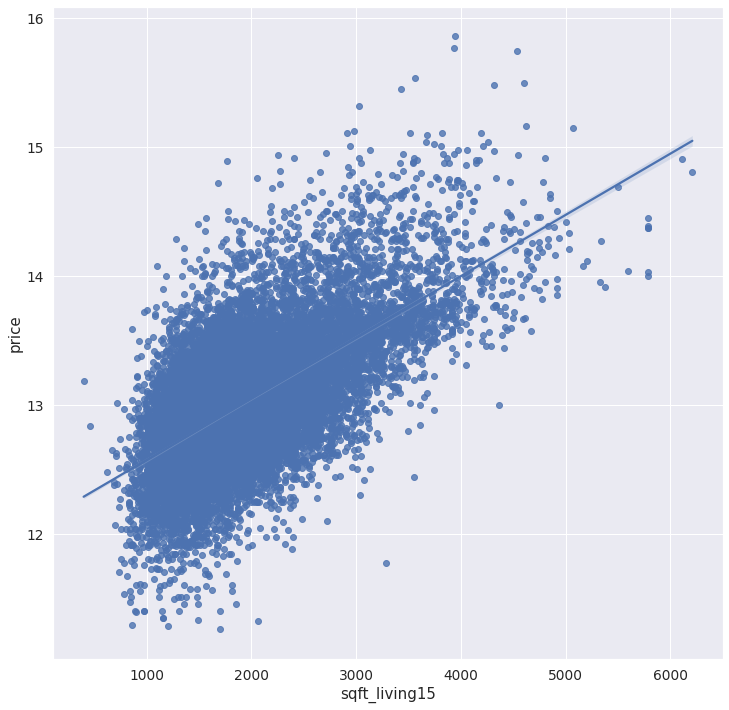

In [196]:
f, ax = plt.subplots(figsize=(12, 12))
fig = sns.regplot(x = 'sqft_living15', y = 'price', data = train)

# 이상치가 꽤나 보임

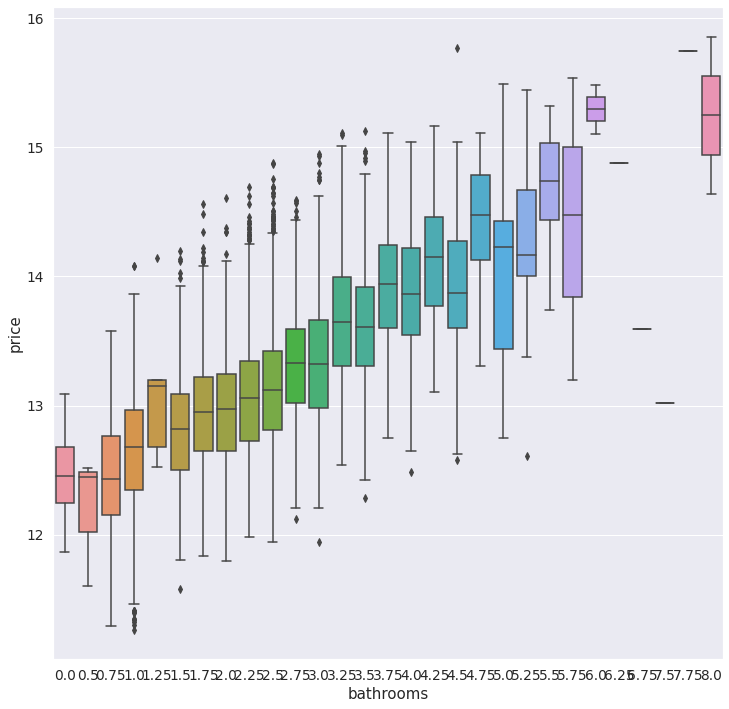

In [197]:
f, ax = plt.subplots(figsize=(12, 12))
fig = sns.boxplot(x = 'bathrooms', y = 'price', data = train)

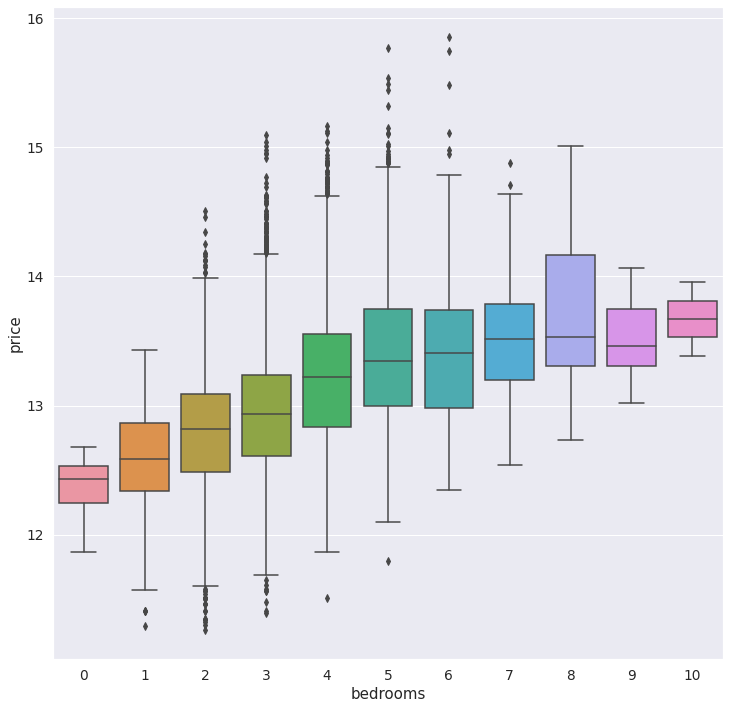

In [198]:
f, ax = plt.subplots(figsize=(12, 12))
fig = sns.boxplot(x = 'bedrooms', y = 'price', data = train)

# 이상치 제거 feat 시각화를 통한 눈분류

In [199]:
# sqft_living
train.loc[train['sqft_living'] > 10000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,201406,15.770310,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
5108,201410,15.856731,6,8.0,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [200]:
# sqft_living15
train.loc[train['sqft_living15'] > 5500]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
816,201406,13.997833,4,1.75,3990,13470,2.0,0,0,3,11,3990,0,2006,0,98059,47.5305,-122.131,5790,13709
1103,201408,14.038655,4,3.75,3830,41263,2.0,0,0,4,11,3830,0,1990,0,98077,47.7237,-122.042,5600,56568
3867,201410,14.392124,4,3.25,4890,13402,2.0,0,0,3,13,4890,0,2004,0,98059,47.5303,-122.131,5790,13539
7246,201412,14.908440,5,5.50,7400,18898,2.0,0,3,3,13,6290,1110,2001,0,98006,47.5431,-122.112,6110,26442
11446,201502,14.375127,6,4.25,5860,13928,2.0,0,3,3,10,4150,1710,2013,0,98006,47.5382,-122.114,5790,13928
13809,201501,14.808763,4,4.00,7850,89651,2.0,0,0,3,12,7850,0,2006,0,98027,47.5406,-121.982,6210,95832
14294,201408,14.030961,5,3.25,5790,13726,2.0,0,3,3,10,4430,1360,2014,0,98006,47.5388,-122.114,5790,13726
14471,201410,14.375127,5,3.25,5790,12739,2.0,0,3,3,10,4430,1360,2014,0,98006,47.5380,-122.114,5790,13928
14981,201501,14.447623,5,3.50,4410,13000,2.0,0,3,3,10,2920,1490,2014,0,98006,47.5382,-122.111,5790,12969


In [201]:
train.loc[train['price'] > 15.5]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,201406,15.770310,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
3134,201408,15.532906,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
5108,201410,15.856731,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,201409,15.744856,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [202]:
train.loc[train['bathrooms'] > 7]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,201410,15.856731,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
5990,201408,13.017005,9,7.50,4050,6504,2.0,0,0,3,7,4050,0,1996,0,98144,47.5923,-122.301,1448,3866
6469,201409,15.744856,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
8912,201405,14.639686,7,8.00,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [203]:
train.loc[train['bedrooms'] > 8]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2912,201405,13.304685,9,4.50,3830,6988,2.5,0,0,3,7,2450,1380,1938,0,98103,47.6927,-122.338,1460,6291
3010,201501,13.458837,9,3.00,3680,4400,2.0,0,0,3,7,2830,850,1908,0,98102,47.6374,-122.324,1960,2450
4291,201408,14.062371,9,4.50,3650,5000,2.0,0,0,3,8,2530,1120,1915,2010,98105,47.6604,-122.289,2510,5000
5990,201408,13.017005,9,7.50,4050,6504,2.0,0,0,3,7,4050,0,1996,0,98144,47.5923,-122.301,1448,3866
9280,201408,13.953533,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
10575,201410,13.384729,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914
12824,201503,13.747233,9,3.00,2820,4480,2.0,0,0,3,7,1880,940,1918,0,98105,47.6654,-122.307,2460,4400


In [204]:
train = train[(train['sqft_living'] <= 10000) & (train['sqft_living15'] <= 5500) & (train['price'] <= 15.5) & (train['bathrooms'] <= 7) & (train['bedrooms'] <= 8)]

In [205]:
# 잘 사라졌는 지 확인
train.loc[train['bedrooms'] > 8]

# 굿

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


# 정규분포로 바꿔주기

In [206]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

<AxesSubplot:xlabel='sqft_living', ylabel='Density'>

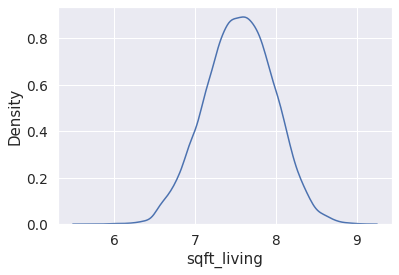

In [207]:
# 확인하기
sns.kdeplot(train['sqft_living'])

# 굿

# 피처 엔지니어링

In [208]:
def feature_engineering(df):
    
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    # 총 면적 계산
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    # 15년 후 면적 대비 거실의 비율 
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    # 뺸 값이 0이면 0 아니면 1을 하는 이진화 
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    
    return df

train = feature_engineering(train)
test = feature_engineering(test)

# 모델 학습

In [209]:
y = train['price']

del train['price']

In [210]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [211]:
# random state 설정
random_state = 42

gboost = GradientBoostingRegressor(random_state = random_state)
xgb = XGBRegressor(random_state = random_state)
lgbm = LGBMRegressor(random_state = random_state)
rf = RandomForestRegressor(random_state = random_state)

models = [gboost, xgb, lgbm, rf]

In [212]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        # train / test 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state = random_state, test_size = 0.2)
        
        # model fitting
        model.fit(X_train, y_train)
        
        # model predict
        y_pred = model.predict(X_test)
        
        # 점수 계산
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index = ['RMSE']).T.sort_values('RMSE', ascending = False)
        
    return score_df        

In [213]:
get_scores(models, train, y)

# gboost는 별로인 듯
# 역시 xgb

,RMSE
GradientBoostingRegressor,132152.831970
RandomForestRegressor,128343.129284
LGBMRegressor,112348.475292
XGBRegressor,110885.305890


# GridSearch

## 앙상블까지 할라니 시간이 너무 오래걸림

In [214]:
# # 찾을 하이퍼파라미터 세팅
# param_grid_rf = {
#     'n_estimators': [100, 200],
#     'max_depth': [5, 10, 20],
# #     'min_samples_split': [2, 5],
# #     'min_samples_leaf': [1, 2]
# }

# param_grid_xgb = {
#     'n_estimators': [100, 200],
# #     'learning_rate': [0.01, 0.1],
#     'max_depth': [3, 5, 10]
# }

# param_grid_lgbm = {
#     'n_estimators': [100, 200],
# #     'learning_rate': [0.01, 0.1],
#     'num_leaves': [31, 50]
# }

In [215]:
# # 그리드 서치 객체 생성
# grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='neg_root_mean_squared_error', cv=5)
# grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, scoring='neg_root_mean_squared_error', cv=5)
# grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, scoring='neg_root_mean_squared_error', cv=5)

# # 그리드 서치 실행
# grid_rf.fit(train, y)
# grid_xgb.fit(train, y)
# grid_lgbm.fit(train, y)

In [216]:
# # 최적의 모델들 추출
# best_rf = grid_rf.best_estimator_
# best_xgb = grid_xgb.best_estimator_
# best_lgbm = grid_lgbm.best_estimator_

In [217]:
# # train 데이터셋을 train과 validation 셋으로 분리
# X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

# # 모델을 X_test 데이터로 예측하여 앙상블
# rf_pred = best_rf.predict(X_test)
# xgb_pred = best_xgb.predict(X_test)
# lgbm_pred = best_lgbm.predict(X_test)

In [218]:
# ensemble_test_pred = (rf_pred + xgb_pred + lgbm_pred) / 3

In [219]:
# # RMSE 계산
# rmse_ensemble_test = rmse(y_test, ensemble_test_pred)
# print(f"Ensemble RMSE on X_test: {rmse_ensemble_test:.4f}")

In [220]:
# ensemble_pred = (best_rf.predict(test) + best_xgb.predict(test) + best_lgbm.predict(test)) / 3

In [224]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'max_depth' : [10, 20, 30]
}

In [225]:
def Grid(model, train, y, param_grid, verbose = 2, n_jobs = 5):
    grid_model = GridSearchCV(model, param_grid = param_grid, scoring = 'neg_mean_squared_error', 
                              cv = 5, verbose = verbose, n_jobs = n_jobs)
    # model fitting
    grid_model.fit(train, y)
    
    # 결과 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # DataFrame 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [226]:
model = LGBMRegressor(random_state = random_state)
Grid(model, train, y, param_grid = param_grid, verbose = 2, n_jobs = 5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
19,0.10,10,200,50,-0.026361,0.162361
22,0.10,20,200,31,-0.026375,0.162405
18,0.10,10,200,31,-0.026472,0.162704
23,0.10,20,200,50,-0.026522,0.162855
17,0.10,10,100,50,-0.026651,0.163252
21,0.10,20,100,50,-0.026838,0.163824
20,0.10,20,100,31,-0.027091,0.164594
16,0.10,10,100,31,-0.027164,0.164816
14,0.10,5,200,31,-0.027177,0.164855
15,0.10,5,200,50,-0.027306,0.165247


In [227]:
model = LGBMRegressor(max_depth = 10, n_estimators = 200, learning_rate = 0.10, num_leaves = 50)

In [228]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    
    prediction = model.predict(test)
    
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    
    submission_path = join(data_dir, 'sample_submission.csv')
    
    submission = pd.read_csv(submission_path)
    
    submission['price'] = prediction
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    
    submission.to_csv(submission_csv_path, index=False)
    
    print('{} saved!'.format(submission_csv_path))

In [229]:
save_submission(model, train, y, test, 'lgbm', rmsle = '0.162361')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.162361.csv saved!


In [ ]:
# Private 점수 : 113779.14765

## 회고
# 욕심을 부리지말자
# 뭔가 10만점을 돌파하려면 앙상블해서 해야할 거 같아서 모델 그리드서치돌리다가 남은 시간이 20분 밖에 안 남은 걸 보고 
# lgbm으로 하이퍼파라미터도 간단하게 설정하고 그리드서치를 돌렸습니다.
# 시간확인을 잘 하자